In [10]:
#writetable("pjtion_corto_tfo", df_pjtion_corto_tfo, separator='\t');
#writetable("pjtion_largo_tfo", df_pjtion_largo_tfo, separator='\t');
#writetable("pjtion_portal_tfo", df_pjtion_portal_tfo, separator='\t');

In [11]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using Bio
set_default_plot_size(28cm, 16cm)

In [12]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [13]:
#Preparo variables
aa3 = 354
aa36 = aa3 - 6
# Uso este index p/ descartar los aminoácidos del extremo
# También necesito el index p/ descartar los aa's q no afectan al pocket
index_tfo = collect(2:119)
index_tfo_3 = map(x -> x*3, repeat(index_tfo, inner=[3])) - repeat([2, 1, 0], outer = [length(index_tfo)]);

pjtion_corto_tfo = Array{Float64}(aa36);
pjtion_largo_tfo = Array{Float64}(aa36);
pjtion_portal_tfo = Array{Float64}(aa36);

In [14]:
# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_tfo, evals_tfo = read_ptraj_modes("/home/german/labo/16/hemo/run/tfo/modes_tfo", aa3);

# Leo los vectores gradiente de c/ cavidad, subsetteo los valores
vtor_tfo_corto = readdlm("/home/german/labo/16/hemo/cavities/displ/vtores/vtor_tfo_corto_0008")
# Descarto los aa's de los extremos
vtor_tfo_corto = vtor_tfo_corto[index_tfo_3]
# Descarto los aa's q no afectan a esta cavidad
reindex_tfo_corto = vtor_tfo_corto .!= 0
vtor_tfo_corto = vtor_tfo_corto[reindex_tfo_corto]
vtor_tfo_corto = vtor_tfo_corto / norm(vtor_tfo_corto)

vtor_tfo_largo = readdlm("/home/german/labo/16/hemo/cavities/displ/vtores/vtor_tfo_largo_0008")
# Descarto los aa's de los extremos
vtor_tfo_largo = vtor_tfo_largo[index_tfo_3]
# Descarto los aa's q no afectan a esta cavidad
reindex_tfo_largo = vtor_tfo_largo .!= 0
vtor_tfo_largo = vtor_tfo_largo[reindex_tfo_largo]
vtor_tfo_largo = vtor_tfo_largo / norm(vtor_tfo_largo)

vtor_tfo_portal = readdlm("/home/german/labo/16/hemo/cavities/displ/vtores/vtor_tfo_portal_0008");
# Descarto los aa's de los extremos
vtor_tfo_portal = vtor_tfo_portal[index_tfo_3]
# Descarto los aa's q no afectan a esta cavidad
reindex_tfo_portal = vtor_tfo_portal .!= 0
vtor_tfo_portal = vtor_tfo_portal[reindex_tfo_portal]
vtor_tfo_portal = vtor_tfo_portal / norm(vtor_tfo_portal);

# Ahora subsetteo también a los modos
modes_tfo_corto = modes_tfo[reindex_tfo_corto, :]
modes_tfo_corto = mapslices(x -> x/norm(x), modes_tfo_corto, 1)

modes_tfo_largo = modes_tfo[reindex_tfo_largo, :]
modes_tfo_largo = mapslices(x -> x/norm(x), modes_tfo_largo, 1)

modes_tfo_portal = modes_tfo[reindex_tfo_portal, :]
modes_tfo_portal = mapslices(x -> x/norm(x), modes_tfo_portal, 1);

In [15]:
for i=1:aa36
    pjtion_corto_tfo[i] = (dot(modes_tfo_corto[:, i], vtor_tfo_corto))^2
    pjtion_largo_tfo[i] = (dot(modes_tfo_largo[:, i], vtor_tfo_largo))^2
    pjtion_portal_tfo[i] = (dot(modes_tfo_portal[:, i], vtor_tfo_portal))^2
end
df_pjtion_corto_tfo = DataFrame(projection = pjtion_corto_tfo);
df_pjtion_largo_tfo = DataFrame(projection = pjtion_largo_tfo);
df_pjtion_portal_tfo = DataFrame(projection = pjtion_portal_tfo);


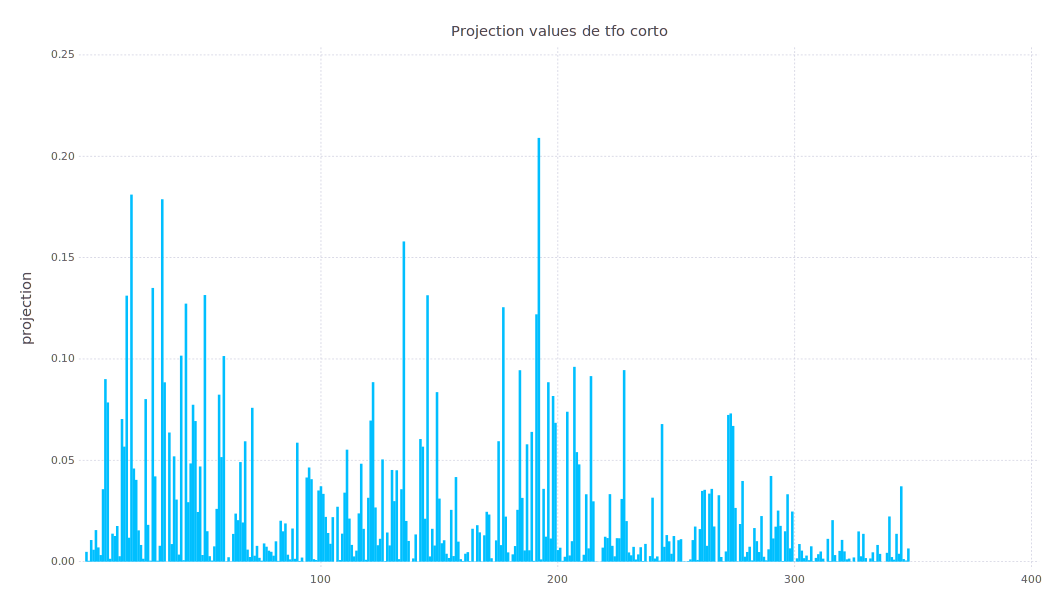

In [16]:
# Plot!
plot(df_pjtion_corto_tfo,
y="projection",  
Geom.bar(position=:dodge), 
Guide.Title("Projection values de tfo corto"),
Coord.Cartesian(xmin=1, xmax=400))
#Guide.xticks(ticks = collect(1:1:11), orientation=:horizontal),
#Guide.yticks(ticks = collect(0.0:0.1:0.3), orientation=:horizontal), 
#Guide.xlabel("SSE participation number"), Guide.ylabel("relative probability"))

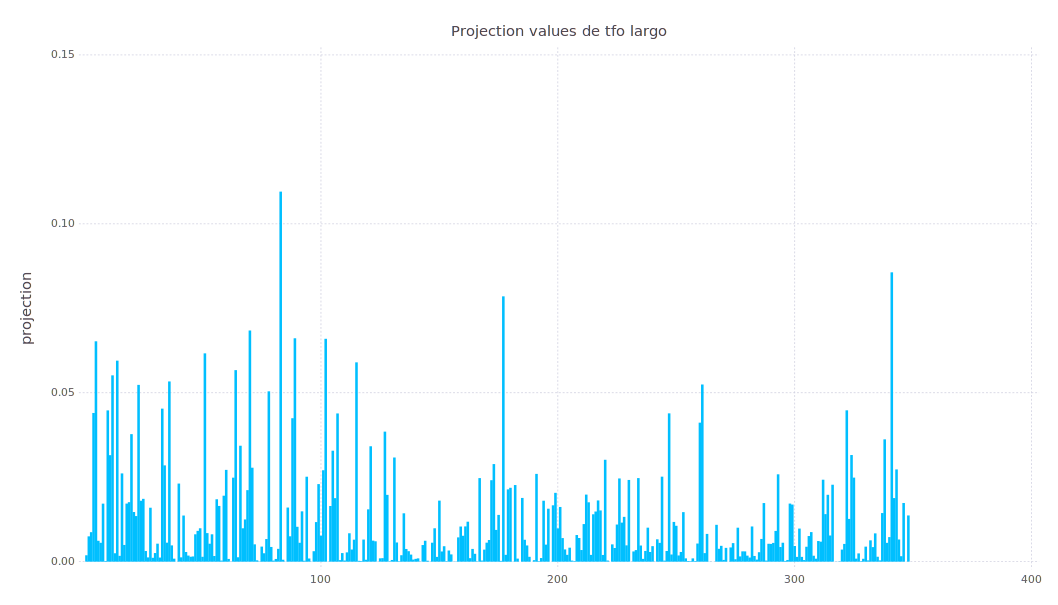

In [17]:
# Plot!
plot(df_pjtion_largo_tfo,
y="projection",  
Geom.bar(position=:dodge), 
Guide.Title("Projection values de tfo largo"),
Coord.Cartesian(xmin=1, xmax=400))
#Guide.xticks(ticks = collect(1:1:11), orientation=:horizontal),
#Guide.yticks(ticks = collect(0.0:0.1:0.3), orientation=:horizontal), 
#Guide.xlabel("SSE participation number"), Guide.ylabel("relative probability"))

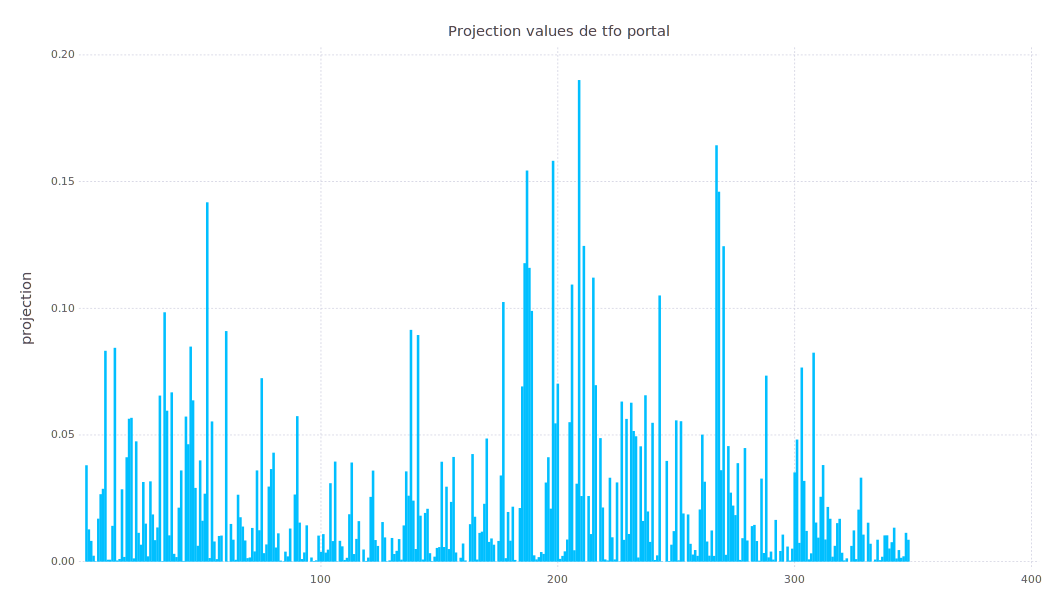

In [18]:
# Plot!
plot(df_pjtion_portal_tfo,
y="projection",  
Geom.bar(position=:dodge), 
Guide.Title("Projection values de tfo portal"),
Coord.Cartesian(xmin=1, xmax=400))
#Guide.xticks(ticks = collect(1:1:11), orientation=:horizontal),
#Guide.yticks(ticks = collect(0.0:0.1:0.3), orientation=:horizontal), 
#Guide.xlabel("SSE participation number"), Guide.ylabel("relative probability"))